In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
# import comet_ml in the top of your file
from comet_ml import Experiment

# Add the following code anywhere in your machine learning file
# experiment = Experiment(api_key="iX5YKStOW8DR7K4XNc7n33Y3i",
#                         project_name="Epilepsy", workspace="perchusha")
import os
import glob
import nibabel as nib
import numpy as np
import pandas as pd
import torch
from tqdm import tqdm

import functools
import numpy as np
from sklearn.metrics import roc_auc_score,accuracy_score
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
import torch
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')
%matplotlib inline

In [2]:
!nvidia-smi

Mon Jun  8 07:40:41 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64       Driver Version: 440.64       CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:83:00.0 Off |                    0 |
| N/A   47C    P0    35W / 250W |   7623MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla P100-PCIE...  Off  | 00000000:89:00.0 Off |                    0 |
| N/A   29C    P0    31W / 250W |  13806MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

In [3]:
print(torch.cuda.device_count())

4


In [4]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
device = "cuda:0" if torch.cuda.is_available() else 'cpu'
print(device)

cuda:0


In [5]:
import sys
sys.path.append("../..")

# import utils 
from utils.viz_tools import plot_central_cuts
from utils.data import MriSegmentation, MriClassification
# from utils import routine

### 0. Soloviev Dataset

#### fcd/no_fcd, one tomograph

In [6]:
soloviev_data = MriClassification(sample='soloviev', data_type = 'img', ignore_missing=True,
                                  image_path='/home/datasets/fcd_classification_bank',
                                  targets_path ='../../targets/targets_fcd_bank.csv',
                                  coord_min=(35,35,35), img_shape=(180,180,180))

  1%|          | 2/181 [00:00<00:13, 12.80it/s]

Assembling data for:  soloviev  sample.


100%|██████████| 181/181 [00:10<00:00, 16.48it/s]


In [7]:
soloviev_data.scan_keys

array(['1.5T_soloviev'], dtype=object)

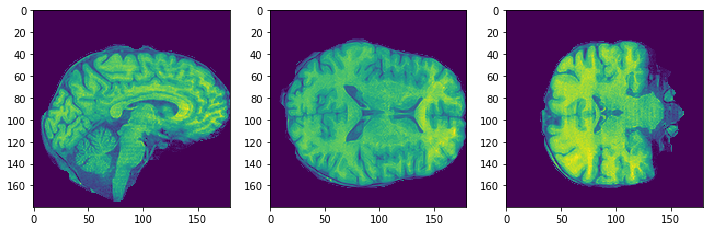

In [8]:
img, target, scan = soloviev_data[0]
plot_central_cuts(img)

In [9]:
soloviev_data.target.value_counts()

1    91
0    90
Name: fcd, dtype: int64

## Pirogov dataset

#### only fcd, one tomograph

In [6]:
fcd_15 = MriClassification(sample='pirogov', prefix='fcd', ignore_missing=True,data_type = 'img',
                         image_path= '/home/datasets/fcd_classification_bank',
                         targets_path= '../../targets/targets_fcd_bank.csv',
                          coord_min=(35,35,35), img_shape=(180,180,180))


  0%|          | 0/15 [00:00<?, ?it/s]

Assembling data for:  pirogov  sample.


100%|██████████| 15/15 [00:01<00:00,  7.71it/s]


In [7]:
img, target, scan = fcd_15[0]

In [8]:
img.shape

torch.Size([1, 180, 180, 180])

In [9]:
fcd_15.target.value_counts()

1    15
Name: fcd, dtype: int64

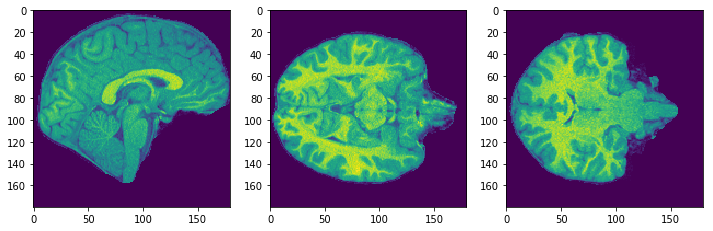

In [10]:
img, target, scan = fcd_15[0]
plot_central_cuts(img)

### 1. Classification w/o data normalisation


In [11]:
import sys
sys.path.append("../")
# from models.cnn_model import CNN # models
from routine import * # validation and train

# experiment.set_name("DilatedCNN, baseline cv")

### 2. Holdout on Soloviev dataset

In [20]:
holdout_idx = soloviev_data.scan[               # without depression (fcd+no_fcd)
    (soloviev_data.scan == 0)&(
    (soloviev_data.misc == 2)|(soloviev_data.misc == 0)
    )
]
print(len(holdout_idx))
test_idx = soloviev_data.scan[soloviev_data.scan == 4] # fcd + no_fcd
print(len(test_idx))
~holdout_idx
train_idx = soloviev_data.scan[
    ~np.isin( 
        soloviev_data.scan.index, #all indexes
        list(np.append(holdout_idx.index,test_idx.index)) # with depression (fcd+no_fcd)
    )
]
print(len(train_idx))

from torch.utils.data import Subset
train_dataset = Subset(soloviev_data, train_idx)

90
0
91


In [16]:
soloviev_data.target[train_idx.index].value_counts()

1    46
0    45
Name: fcd, dtype: int64

### 3. Train for finetune the model (on Soloviev holdout )

In [17]:
from models.cnn_model import DilatedCNN
model_params = {
    "input_shape": (180,180,180)}

train_dataset = soloviev_data
model_dilatedCnn = DilatedCNN(**model_params)
model, optimizer, scheduler = create_model_opt(model_dilatedCnn)

batch_size = 10

split_ = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)

#train_idx, val_idx = list(split_.split(X=np.arange(len(train_dataset)), y=train_dataset.target))[0]
# Train on Soloviev holdout 
train_idx, val_idx = list(split_.split(X=np.arange(len(holdout_idx)), y=soloviev_data.target[holdout_idx.index]))[0]
train_dataset = soloviev_data
train_loader = DataLoader(Subset(train_dataset, train_idx),
                                      shuffle=False,
                                      batch_size=batch_size,
                                      drop_last=False)

val_loader = DataLoader(Subset(train_dataset, val_idx),
                                shuffle=False,
                                batch_size=batch_size,
                                drop_last=False)

In [ ]:
%%time
torch.cuda.empty_cache()

training_params = {
    "model": model_cnn,
    "optimizer": optimizer,
    "scheduler": scheduler,
    "train_dataloader": train_loader,
    "val_dataloader": val_loader,
    "device": device,
    "metric": roc_auc_score,
    "experiment": experiment,
    "max_epoch": 20,
    "verbose": 1,
}


last_train_loss, last_train_metric, last_val_loss, last_val_metric = train(**training_params)

### 4. CV on the best performing model

Epoch 17 of 30 took 24.215s
  training loss (in-iteration): 	0.681021
  validation loss: 			0.698310
  training roc_auc_score: 			0.85
  validation roc_auc_score: 			0.81


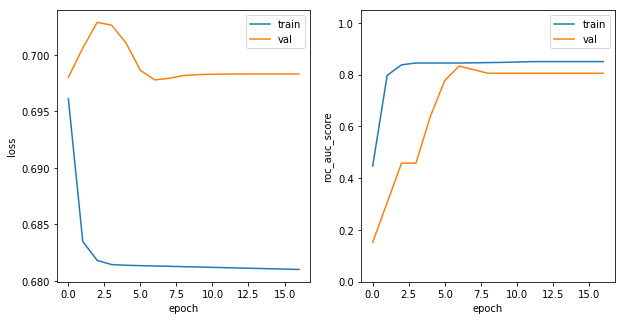

<Figure size 720x360 with 0 Axes>

 88%|████████▊ | 7/8 [00:20<00:02,  2.94s/it]

KeyboardInterrupt: 

In [14]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
metric = roc_auc_score

cv_params = {
    "cnn_model": model_dilatedCnn,
    "batch_size": 10,
    "train_dataset": soloviev_data,
    "device": device,
    "cv": cv,
    "metric": roc_auc_score,
    "holdout_idx":holdout_idx,
    "experiment": False,
    "max_epoch": 30,

}


val_metrics = cross_val_score(**cv_params)
print("val {}s: {}".format(metric.__name__, val_metrics))
print("val {} mean: {}".format(metric.__name__, np.mean(val_metrics)))
print("val {} std: {}".format(metric.__name__, np.std(val_metrics)))

### CV on train

In [14]:
from models.cnn_model import DilatedCNN
model_params = {
    "input_shape": (180,180,180)}

train_dataset = soloviev_data
model_dilatedCnn = DilatedCNN(**model_params)
model, optimizer, scheduler = create_model_opt(model_dilatedCnn)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

metric = roc_auc_score

cv_params = {
    "cnn_model": model_dilatedCnn,
    "batch_size": 10,
    "train_dataset": soloviev_data,
    "device": device,
    "cv": cv,
    "metric": roc_auc_score,
    "holdout_idx":train_idx,
    "experiment": False,
    "max_epoch": 30,
    "model_load_path": '/home/Perchenko/mri-epilepsy-segmentation/classification/baseline/checkpoint.pth'

}


val_metrics = cross_val_score(**cv_params)
print("val {}s: {}".format(metric.__name__, val_metrics))
print("val {} mean: {}".format(metric.__name__, np.mean(val_metrics)))
print("val {} std: {}".format(metric.__name__, np.std(val_metrics)))

100%|██████████| 2/2 [00:03<00:00,  1.55s/it]

val roc_auc_scores: [0.5285714285714286, 0.7662337662337662, 0.8961038961038961, 0.8125, 0.825]
val roc_auc_score mean: 0.7656818181818181
val roc_auc_score std: 0.12565201849578905


### CV on holdout

In [15]:
from models.cnn_model import DilatedCNN
model_params = {
    "input_shape": (180,180,180)}

train_dataset = soloviev_data
model_dilatedCnn = DilatedCNN(**model_params)
model, optimizer, scheduler = create_model_opt(model_dilatedCnn)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

metric = roc_auc_score

cv_params = {
    "cnn_model": model_dilatedCnn,
    "batch_size": 10,
    "train_dataset": soloviev_data,
    "device": device,
    "cv": cv,
    "metric": roc_auc_score,
    "holdout_idx":holdout_idx,
    "experiment": False,
    "max_epoch": 30,
    "model_load_path": '/home/Perchenko/mri-epilepsy-segmentation/classification/baseline/checkpoint.pth'

}


val_metrics = cross_val_score(**cv_params)
print("val {}s: {}".format(metric.__name__, val_metrics))
print("val {} mean: {}".format(metric.__name__, np.mean(val_metrics)))
print("val {} std: {}".format(metric.__name__, np.std(val_metrics)))

100%|██████████| 2/2 [00:03<00:00,  1.58s/it]

val roc_auc_scores: [0.75, 0.8611111111111112, 0.7037037037037037, 0.6375, 0.9506172839506173]
val roc_auc_score mean: 0.7805864197530864
val roc_auc_score std: 0.11199546894072347


### CV in full Soloviev

In [22]:
from models.cnn_model import DilatedCNN
model_params = {
    "input_shape": (180,180,180)}

train_dataset = soloviev_data
model_dilatedCnn = DilatedCNN(**model_params)
model, optimizer, scheduler = create_model_opt(model_dilatedCnn)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
metric = roc_auc_score

cv_params = {
    "cnn_model": model_dilatedCnn,
    "batch_size": 10,
    "train_dataset": soloviev_data,
    "device": device,
    "cv": cv,
    "metric": roc_auc_score,
    "experiment": False,
    "max_epoch": 30,
    "model_load_path": '/home/Perchenko/mri-epilepsy-segmentation/classification/baseline/checkpoint.pth'

}


val_metrics = cross_val_score(**cv_params)
print("val {}s: {}".format(metric.__name__, val_metrics))
print("val {} mean: {}".format(metric.__name__, np.mean(val_metrics)))
print("val {} std: {}".format(metric.__name__, np.std(val_metrics)))

100%|██████████| 4/4 [00:05<00:00,  1.42s/it]

val roc_auc_scores: [0.5555555555555556, 0.6481481481481481, 0.7623456790123457, 0.7530864197530864, 0.6018518518518519]
val roc_auc_score mean: 0.6641975308641976
val roc_auc_score std: 0.08183145938922551


### CV on Pirogov dataset

In [12]:
from models.cnn_model import DilatedCNN
model_params = {
    "input_shape": (180,180,180)}

train_dataset = fcd_15
model_dilatedCnn = DilatedCNN(**model_params)
model, optimizer, scheduler = create_model_opt(model_dilatedCnn)


split_ = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)

train_idx, val_idx = list(split_.split(X=np.arange(len(train_dataset)), y=train_dataset.target))[0]

test_loader_15 = torch.utils.data.DataLoader(fcd_15, batch_size=30, 
                             num_workers=0, drop_last=False, shuffle=False)


In [14]:
from models.cnn_model import DilatedCNN
model_params = {
    "input_shape": (180,180,180)}

model_dilatedCnn = DilatedCNN(**model_params)
model, optimizer, scheduler = create_model_opt(model_dilatedCnn)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

metric = accuracy_score

cv_params = {
    "cnn_model": model_dilatedCnn,
    "batch_size": 30,
    "train_dataset": fcd_15,
    "device": device,
    "cv": cv,
    "metric": accuracy_score,
    "experiment": False,
    "max_epoch": 30,
    "model_load_path": '/home/Perchenko/mri-epilepsy-segmentation/classification/baseline/checkpoint.pth'

}


val_metrics = cross_val_score(**cv_params)
print("val {}s: {}".format(metric.__name__, val_metrics))
print("val {} mean: {}".format(metric.__name__, np.mean(val_metrics)))
print("val {} std: {}".format(metric.__name__, np.std(val_metrics)))

100%|██████████| 1/1 [00:00<00:00,  1.97it/s]

val accuracy_scores: [0.6666666666666666, 0.0, 0.3333333333333333, 0.3333333333333333, 0.6666666666666666]
val accuracy_score mean: 0.4
val accuracy_score std: 0.2494438257849294


### CV with accuracy on full Soloviev

In [23]:
from models.cnn_model import DilatedCNN
model_params = {
    "input_shape": (180,180,180)}

train_dataset = soloviev_data
model_dilatedCnn = DilatedCNN(**model_params)
model, optimizer, scheduler = create_model_opt(model_dilatedCnn)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


cv_params = {
    "cnn_model": model_dilatedCnn,
    "batch_size": 10,
    "train_dataset": soloviev_data,
    "device": device,
    "cv": cv,
    "metric": accuracy_score,
    "experiment": False,
    "max_epoch": 30,
    "model_load_path": '/home/Perchenko/mri-epilepsy-segmentation/classification/baseline/checkpoint.pth'

}


val_metrics = cross_val_score(**cv_params)
print("val {}s: {}".format(metric.__name__, val_metrics))
print("val {} mean: {}".format(metric.__name__, np.mean(val_metrics)))
print("val {} std: {}".format(metric.__name__, np.std(val_metrics)))

100%|██████████| 4/4 [00:06<00:00,  1.58s/it]

val accuracy_scores: [0.5405405405405406, 0.6111111111111112, 0.6111111111111112, 0.7222222222222222, 0.5277777777777778]
val accuracy_score mean: 0.6025525525525526
val accuracy_score std: 0.06914345126538683
